In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from ipywidgets import interact

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

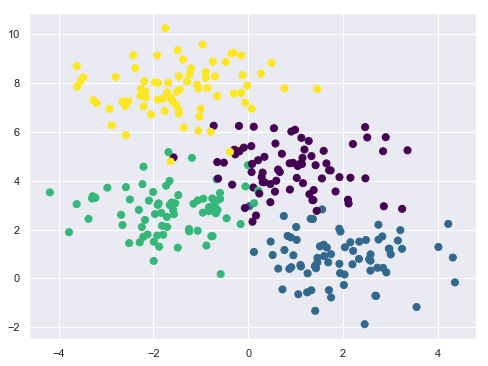

In [28]:
plt.figure(figsize=(8, 6))

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')

In [29]:
plt.scatter?

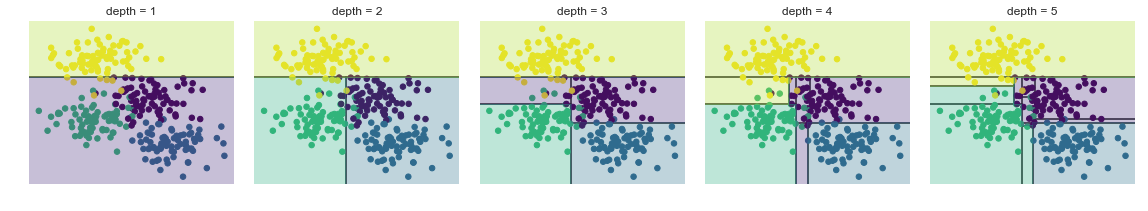

In [47]:
def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis',
                           zorder=3)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)

fig, ax = plt.subplots(1, 5, figsize=(16, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

for axi, depth in zip(ax, range(1, 6)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))

In [48]:
def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 2, 3, 4, 5])

In [49]:
plot_tree_interactive(X, y)

interactive(children=(Dropdown(description='depth', index=4, options=(1, 2, 3, 4, 5), value=5), Output()), _do…

<function __main__.plot_tree_interactive.<locals>.interactive_tree(depth=5)>

In [50]:
tree = DecisionTreeClassifier().fit(X, y)

In [65]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, 
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), 
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)
    ax.set(xlim=xlim, ylim=ylim)

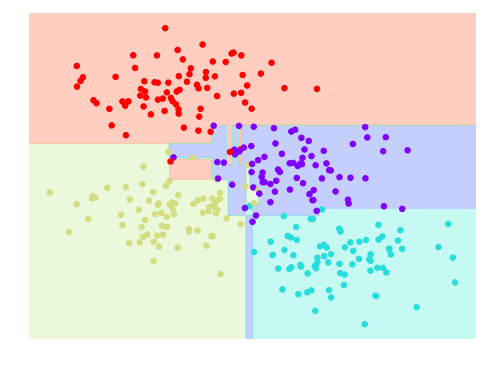

In [66]:
plt.figure(figsize=(8, 6))
visualize_classifier(DecisionTreeClassifier(), X, y)

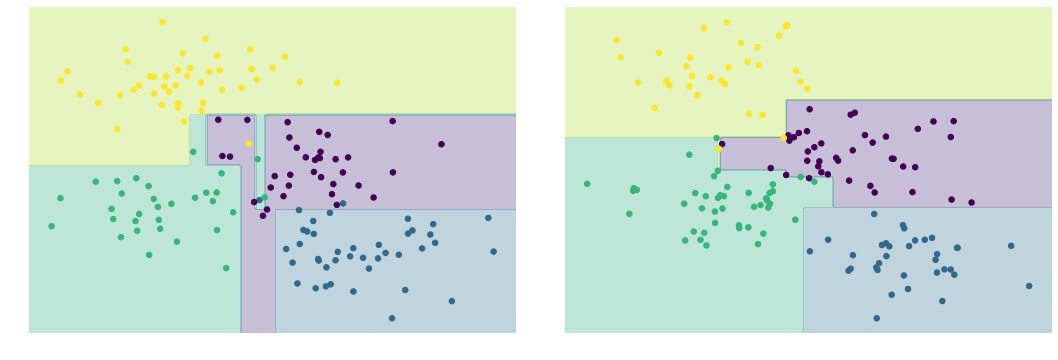

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])

### What is Ensembling?

Ensemble methods, which combines several algorithms to produce better predictive performance than utilizing a single algorithm. The main principle behind the ensemble model is that a group of weak learners come together to form a strong learner.

In the context of decision trees there are two different ensembling techniques

1. Bagging

2. Boosting

### What is Bagging?

Bagging also known as **B**ootstrap **Agg**regation is used when our goal is to reduce the variance of a decision tree. Here idea is to create several subsets of data from training sample chosen randomly with replacement. Now, each collection of subset data is used to train their decision trees. As a result, we end up with an ensemble of different models. Average of all the predictions from different trees are used which is more robust than a single decision tree.

### How is Random Forest related to Bagging?

Random Forest is an extension over bagging. It takes one extra step where in addition to taking the random subset of data, it also takes the random selection of features rather than using all features to grow trees. When you have many random trees. It’s called Random Forest

### Hand Written Digit Classification Using Random Forest

In [73]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [74]:
digits.images.shape

(1797, 8, 8)

The images data is a three-dimensional array: 1,797 samples, each consisting of an
8×8 grid of pixels.Let’s visualize the first 64 of these

In [71]:
fig.add_subplot?

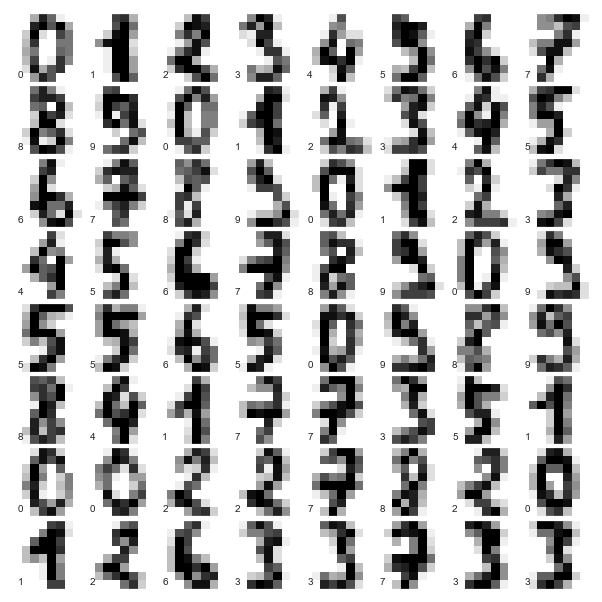

In [75]:
# set up the figure
fig = plt.figure(figsize=(8, 8))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[]) # https://www.geeksforgeeks.org/python-matplotlib-pyplot-ticks/
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
     # imshow( I ) displays the grayscale image I in a figure
    #the insertion of something of a different nature into something else.
   
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [76]:
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [77]:
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


In [78]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.94      0.96        50
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.96      0.98      0.97        46

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



• True Positive (TP) : Observation is positive, and is predicted to be positive.
• False Negative (FN) : Observation is positive, but is predicted negative.
• True Negative (TN) : Observation is negative, and is predicted to be negative.
• False Positive (FP) : Observation is negative, but is predicted positive.

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_true.


A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

In [80]:
sns.heatmap?

Text(108.62,0.5,'predicted label')

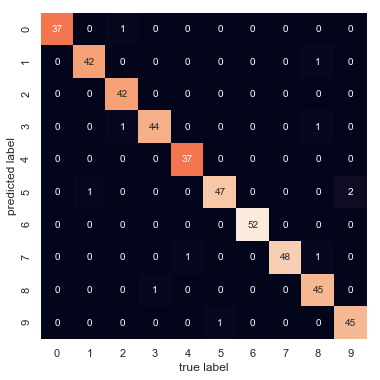

In [86]:
mat = confusion_matrix(ytest, ypred)
plt.figure(figsize=(8, 6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)#.T here is transpose
plt.xlabel('true label')
plt.ylabel('predicted label')

## Summary of Random Forest

*Random forests are a powerful method with several advantages*

1. Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.

2. The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the predict_proba() method).

3. The nonparametric model is extremely flexible, and can thus perform well on tasks that are underfit by other estimators.